## Data Preprocessing for Norman et al. 2019 dataset 

This notebook is largely derived from the preprocessing followed by Lotfollahi, Mohammad, et al. "Predicting cellular responses to complex perturbations in high‐throughput screens." Molecular systems biology 19.6 (2023): e11517. 

See https://github.com/facebookresearch/CPA/blob/main/preprocessing/Norman19.ipynb

In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize']=(5, 5)
sc.settings.verbosity = 3
sc.logging.print_header()
#os.chdir('./')


%load_ext autoreload
%autoreload 2 

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.1 scipy==1.7.1 pandas==1.3.1 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.10 pynndescent==0.5.4


In [11]:

import sys
sys.path.append('../')

In [12]:
sc.set_figure_params(dpi=100)

## loading the raw data

In [2]:
adata = sc.read("../datasets/Norman2019_raw_all_genes.h5ad")

(array([2204., 2462., 1592.,    0.,  681.,  295.,    0.,   86.,   26.,
           7.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

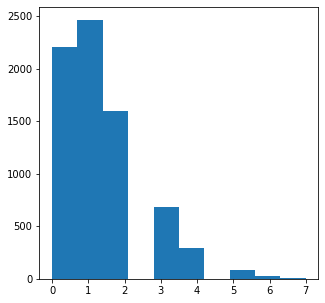

In [7]:
plt.hist(adata[adata.obs['perturbed']=='control'].X[:,20].toarray())

In [14]:
needed_obs = adata.obs[["guide_identity", "UMI_count","gemgroup","good_coverage","number_of_cells"]].copy()

In [15]:
adata_new = sc.AnnData(adata.X.copy(), obs=needed_obs, var=adata.var.copy())

In [16]:
adata_new

AnnData object with n_obs × n_vars = 93658 × 24665
    obs: 'guide_identity', 'UMI_count', 'gemgroup', 'good_coverage', 'number_of_cells'
    var: 'gene_name', 'mean', 'std', 'cv', 'fano', 'in_matrix'

### check all ctrl guides

In [17]:
list_control = []
for i in np.unique(adata_new.obs["guide_identity"]):
   m = re.match(r"NegCtrl(.*)_NegCtrl(.*)+NegCtrl(.*)_NegCtrl(.*)", i)
   if m :
    list_control.append(m.group())

remove "NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0" suggested by authors

In [18]:
adata_new = adata_new[adata_new.obs["guide_identity"] != "NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0"] 

/lfs/turing1/0/yhr/torch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
adata_new

View of AnnData object with n_obs × n_vars = 91205 × 24665
    obs: 'guide_identity', 'UMI_count', 'gemgroup', 'good_coverage', 'number_of_cells'
    var: 'gene_name', 'mean', 'std', 'cv', 'fano', 'in_matrix'

merge all controls 

In [20]:
adata_new.obs["guide_merged"] = adata_new.obs["guide_identity"]

Trying to set attribute `.obs` of view, copying.


In [21]:
for i in np.unique(adata_new.obs["guide_merged"]):
   m = re.match(r"NegCtrl(.*)_NegCtrl(.*)+NegCtrl(.*)_NegCtrl(.*)", i)
   if m :
        adata_new.obs["guide_merged"].replace(i,"ctrl",inplace=True)

relabeling

In [22]:
old_pool = []
for i in np.unique(adata_new.obs["guide_merged"]):
    if i == "ctrl":
        old_pool.append(i)
        continue
    split = i.split("__")[1]
    split = split.split("_")
    for j, string in enumerate(split):
        if "NegCtrl" in split[j]:
            split[j] = "ctrl"
    if len(split) == 1:
        if split[0] in old_pool:
            print("old:",i, "new:",split[0])
        adata_new.obs["guide_merged"].replace(i,split[0],inplace=True)
        old_pool.append(split[0])
    else:
        if f"{split[0]}+{split[1]}" in old_pool:
            print("old:",i, "new:",f"{split[0]}+{split[1]}")
        adata_new.obs["guide_merged"].replace(i, f"{split[0]}+{split[1]}",inplace=True)
        old_pool.append(f"{split[0]}+{split[1]}")

old: HOXC13_NegCtrl0__HOXC13_NegCtrl0_2 new: HOXC13+ctrl
old: TGFBR2_IGDCC3__TGFBR2_IGDCC3_2 new: TGFBR2+IGDCC3
old: ZBTB10_NegCtrl0__ZBTB10_NegCtrl0_2 new: ZBTB10+ctrl


In [23]:
adata_new.obs["guide_merged"]

cell_barcode
AAACCTGAGGCATGTG-1     TSC22D1+ctrl
AAACCTGAGGCCCTTG-1      KLF1+MAP2K6
AAACCTGCACGAAGCA-1             ctrl
AAACCTGCAGACGTAG-1    CEBPE+RUNX1T1
AAACCTGCAGCCTTGG-1       MAML2+ctrl
                          ...      
TTTGTCAGTCATGCAT-8     RHOXF2BB+SET
TTTGTCATCAGTACGT-8       FOXA3+ctrl
TTTGTCATCCACTCCA-8       CELF2+ctrl
TTTGTCATCCCAACGG-8      BCORL1+ctrl
TTTGTCATCTGGCGAC-8      MAP4K3+ctrl
Name: guide_merged, Length: 91205, dtype: category
Categories (284, object): ['AHR+FEV', 'AHR+KLF1', 'AHR+ctrl', 'ARID1A+ctrl', ..., 'ZC3HAV1+HOXC13', 'ZC3HAV1+ctrl', 'ZNF318+FOXL2', 'ZNF318+ctrl']

# preprocessing 

Keep the count data in a counts layer

In [24]:
adata_new.layers["counts"] = adata_new.X.copy()

Normalization and HVG selection

In [49]:
sc.pp.normalize_total(adata_new)
sc.pp.log1p(adata_new)
sc.pp.highly_variable_genes(adata_new,n_top_genes=5000, subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:43)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [50]:
adata_new

AnnData object with n_obs × n_vars = 91205 × 24665
    obs: 'guide_identity', 'UMI_count', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'gene_name', 'mean', 'std', 'cv', 'fano', 'in_matrix', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Keep expression for all genes that are perturbed

In [36]:
conditions = [(c.split('+')[0], c.split('+')[1]) for c in adata_new.obs['guide_merged'] if '+' in c]
conditions = [item for sublist in conditions for item in sublist]
genes_to_keep = np.unique(conditions)

In [37]:
map_dict = {i:i for i in adata_new.var['gene_name'].values}
map_dict['CBARP']='C19orf26'
map_dict['FOXL2NB']='C3orf72'
map_dict['RP5-862P8.2']='KIAA1804'
map_dict['RHOXF2B']='RHOXF2BB'

adata_new.var['gene_name'] = adata_new.var.gene_name.map(map_dict)

In [51]:
adata_new.var['highly_variable'] = adata_new.var['highly_variable'] + adata_new.var.gene_name.isin(genes_to_keep)

In [52]:
adata_new = adata_new[:,adata_new.var['highly_variable'] == True]

/lfs/turing1/0/yhr/torch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [53]:
adata_new

View of AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'guide_identity', 'UMI_count', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_merged', 'dose_val', 'condition', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'gene_name', 'mean', 'std', 'cv', 'fano', 'in_matrix', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

# Prepare for the model

In [39]:
adata_new.obs['dose_val'] = 'nan'

In [40]:
adata_new.obs['dose_val'].loc[
    adata_new.obs['guide_merged']=="ctrl"
] = '1'

adata_new.obs['dose_val'].loc[
    adata_new.obs['guide_merged']!="ctrl"
] = "1+1"

/lfs/turing1/0/yhr/torch/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [41]:
adata_new.obs["condition"] = adata_new.obs["guide_merged"]
adata_new.obs['cell_type'] = 'A549'
adata_new.obs['control'] = [1 if x == 'ctrl' else 0 for x in adata_new.obs.condition.values]

In [42]:
adata_new.obs['drug_dose_name'] = adata_new.obs.condition.astype(str) + '_' + adata_new.obs.dose_val.astype(str)

In [43]:
adata_new.obs['cov_drug_dose_name'] = adata_new.obs.cell_type.astype(str) + '_' + adata_new.obs.drug_dose_name.astype(str)

In [45]:
from scipy.sparse import csr_matrix
adata_new.X = csr_matrix(adata_new.X)

In [47]:
## Saving  h5ad
adata_new.write_h5ad('../datasets/Norman2019_all_genes.h5ad')

DE test

In [54]:
from compert.helper import rank_genes_groups_by_cov

In [55]:
rank_genes_groups_by_cov(adata_new, groupby='cov_drug_dose_name', covariate='cell_type', control_group='ctrl_1', n_genes=20)

A549
ranking genes


Trying to set attribute `.uns` of view, copying.
/lfs/turing1/0/yhr/torch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:381: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/lfs/turing1/0/yhr/torch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:383: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/lfs/turing1/0/yhr/torch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:386: PerformanceWarning: DataFrame is highly fragmented.  This is 

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:53)


Trying to set attribute `.uns` of view, copying.


saving to new object

In [56]:
to_pick = adata_new.obs[["cov_drug_dose_name","dose_val","control","condition","guide_identity","drug_dose_name","cell_type"]]

In [57]:
adata_new_small = sc.AnnData(adata_new.X, obs=to_pick,
                             var=adata_new.var, uns=adata_new.uns)

In [58]:
adata_new_small.layers = adata_new.layers

In [64]:
adata_new_small.write_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts.h5ad')